In [1]:
import numpy as np
from scipy.optimize import minimize
from scipy.stats import ortho_group
import scipy as sp
import sympy as sm
import scipy.integrate as integrate
import matplotlib.pyplot as plt
import types
import math
import random

In [2]:
class Remez:

    def __init__(self, f_: types.FunctionType, lb_: float, ub_: float, n_: int , MAX_ITER_: int):
        self.f = f_
        self.lb = lb_
        self.ub = ub_
        self.n = n_
        self.MAX_ITER = MAX_ITER_
        self.ys = np.zeros(n_ + 2)
        self.iterations = 0

    def Error(self, x: float, alphas: np.ndarray):
        # x is the evaluation point
        # alphas are the coefficients for the approximating polynomial
        # n is the degree of approximating polynomial

        poly = 0
        for j in range(self.n+1):
            poly += alphas[j]*(x**(float(j)))

        return self.f(x) - poly

    def find_maxs(self, alphas: np.ndarray)-> np.array:
        ep = 1e-6
        xlen = (self.ub - self.lb) * 1000
        xs = np.linspace(self.lb, self.ub, xlen)
        fxs = np.abs(self.Error(xs, alphas))
        #plt.plot(fxs)
        dfxs = np.zeros(xlen-1)

        for i in range(xlen-1):
            dfxs[i] = (fxs[i+1] - fxs[i]) / ep

        maximizers = []

        for i in range(xlen-2):
            if dfxs[i] > 0 and dfxs[i+1] < 0:
                maximizers.append((xs[i] + xs[i+1])/2.) 

        #plt.plot(dfxs)

        xstar = np.array(maximizers)
        
        return xstar

    def form_mat(self, xs: np.ndarray):
        # Forms the matrix for the Remez Algorithm
        # n is the degree of polynomial we are approximating with
        n = xs.size - 2 
        
        #A is size n+2 x n+1
        A = np.zeros((n+2, n+2))
        
        for i in range(n+2):
            for j in range(n+2):
                if j == n+1:
                    A[i, j] = (-1)**(i+1)
                else:
                    A[i][j] = xs[i]**j
        return A    

    def convergence(self, xs: np.ndarray, alphas: np.ndarray):
        eps = 1e-5

        f_maxs = self.Error(xs, alphas)
        for i in range(len(f_maxs)-1):
            if abs(abs(f_maxs[i]) - abs(f_maxs[i+1])) > eps:
                return False
            if f_maxs[i] * f_maxs[i+1] > 0:
                return False
            
        return True

    def remez(self):
        xs = np.linspace(self.lb, self.ub, self.n+2)
        
        it = 0
        while it < self.MAX_ITER:
            A = self.form_mat(xs)
            bs = self.f(xs)
            
            # LU decomp on A to improve stability 
            lu, piv = sp.linalg.lu_factor(A)
            ys = sp.linalg.lu_solve((lu, piv), bs)

            ang = self.find_maxs(ys[:-1])
            if self.convergence(ang, ys[:-1]):
                self.ys = ys
                self.iterations = it
                return
            else:
                # Replace the closest points in xs with angs
                for i in range(ang.size):
                    distx = np.zeros_like(xs)
                    for j in range(len(xs)):
                        distx[j] = abs(xs[j] - ang[i])
                    replaceIdx = np.argmin(distx)
                    xs[replaceIdx] = ang[i]
            it+=1
        self.ys = ys
        self.iterations = it
        print("Remez needs more iterations")         

In [3]:
def f(x: np.ndarray):
    return 1./x


In [4]:
n = 4
ub = 5
lb = 1
MAX_ITER = 100

my_remez = Remez(f, lb, ub, n, MAX_ITER)
my_remez.remez()
ys = my_remez.ys

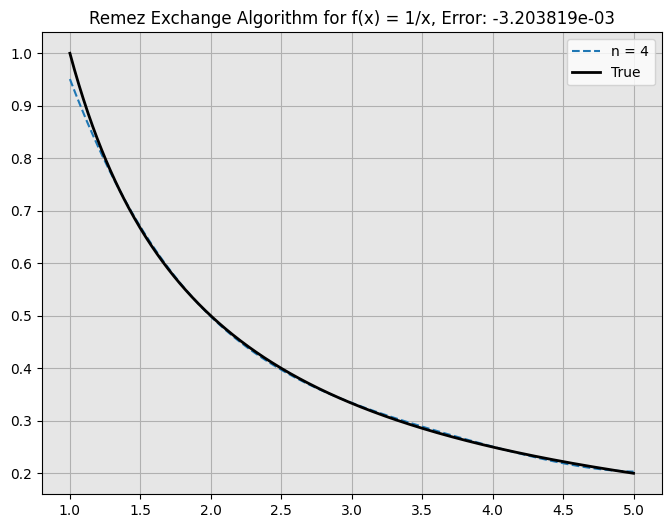

In [5]:
x_vals = np.linspace(lb, ub, 500)
x_ticks = np.round(np.linspace(lb + (ub - lb)/5, ub - (ub - lb)/5, 5), 2)
f_true = f(x_vals)
fig, axs = plt.subplots(1, 1, figsize=(8, 6))
        
poly_approx = np.polyval(ys[::-1][1:], x_vals)

axs.plot(x_vals, poly_approx, '--', label=f"n = {n}" , zorder = 1)  

axs.plot(x_vals, f_true, label=r"True", color='k', zorder = 2, linewidth = 2)
axs.legend()
axs.grid(True)
axs.set_axisbelow(True)
plt.gca().set_facecolor((0.9, 0.9, 0.9)) 
axs.set_title(f"Remez Exchange Algorithm for f(x) = 1/x, Error: {ys[-1]:e}")
plt.show()

In [6]:
# Degree first, then down 
x_vals = np.linspace(1, 5, 1000)
poly_approx = np.polyval(ys[::-1][1:], x_vals)

In [7]:
# Exercise 20, part 2
# Getting random symmetric matrix
size = 1000
Q = ortho_group.rvs(size)
Evals = np.random.uniform(1, 5, size)
R = np.diag(Evals)
Mat = Q @ R @ Q.T
b = np.random.uniform(0, 1, size)
Actual_sol = sp.linalg.solve(Mat,b, assume_a='pos')

In [8]:
# Estimating the Soln of the system with my poly_approx
# Backward
Backward_error = np.linalg.norm(poly_approx - Actual_sol, ord = 2)/ np.linalg.norm(Actual_sol, ord=2)
Forward_error =  np.linalg.norm(Mat @ poly_approx - b, ord=2) / np.linalg.norm(b, ord = 2)

In [9]:
print("Backward_error: ", Backward_error )
print("Forward_error: ", Forward_error)

Backward_error:  1.2148318461739505
Forward_error:  1.834141056670257


In [11]:
def mapping(x):
    #[1,5] -> [-1, 1]
    return 0.5 * x - 3/2
def unmapping(x):
    #[-1, 1] -> [1, 5]
    return 2*x+3

C:\Users\Caleb\AppData\Local\Temp\ipykernel_17992\2767678858.py:12: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  return integrate.quad(sm.lambdify(x, inte, modules = ['numpy']), -1, 1)[0]


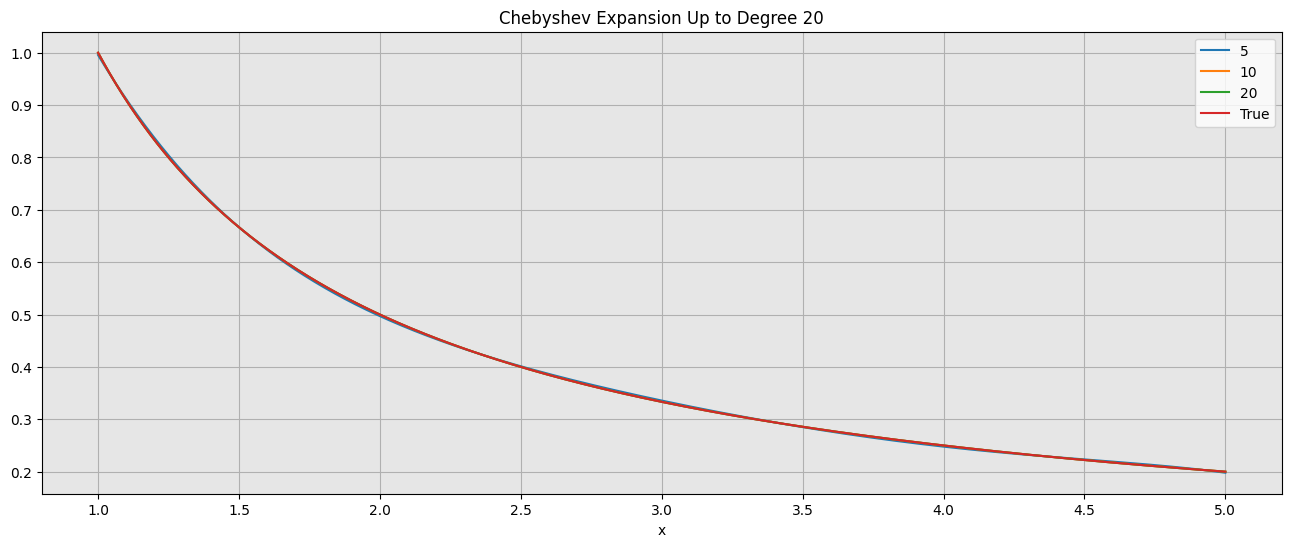

In [15]:
def coeff_eval(x: sm.core.symbol.Symbol, f : sm.Function, Cheby_poly : sm.Function, k: int):
    """
    Calcuates the Coefficients to the
    Chebyshev expansion. 
    """
    inte = 0
    if k == 0:
        inte = (1./sm.pi) * f / (sm.sqrt(1 - x**2))
    else :
        inte = (2. / sm.pi) * f * Cheby_poly / (sm.sqrt(1 - x**2))
    
    return integrate.quad(sm.lambdify(x, inte, modules = ['numpy']), -1, 1)[0]
   
    
def Cheb (x : sm.core.symbol.Symbol, n_eval: int):
    """
    Returns the n-th Chebyshev polynomial.
    """
    j = sm.symbols('j', integer = True)
    n = sm.Symbol('n', integer = True)
    series = sm.Sum(sm.binomial(n, 2*j)* (x**2 - 1)**j * x**(n - 2*j), (j, 0, sm.floor(n/2)))
    return series.subs({n: n_eval}).doit()

def Cheb_expansion(f : sm.Function, k : int, cheb_dict: dict):
    x = sm.Symbol('x')    
    cheb_coeff = np.zeros(k+1)
    cheb_funcs = []
    for i in range(k+1):
        cheb = Cheb(x, i)
        if i not in cheb_dict.keys():
            cheb_coeff[i] = coeff_eval(x, f, cheb, i)    
            cheb_dict[i] = cheb_coeff[i]
        else :
            cheb_coeff[i] = cheb_dict[i]
            
        cheb_funcs.append(cheb) 

    return cheb_coeff, cheb_funcs

def sup_norm(f_true : np.ndarray, f_approx : np.ndarray):
    f_diff = np.abs(f_true - f_approx)
    return np.max(f_diff)



### COMPUTING THE COEFFICIENTS
cheb_dict = {}

xs = np.linspace(1, 5, size)
x = sm.Symbol('x')
f_map = 1/(2*x+3)

ks = range(1, 21, 1)
approxs = np.zeros((len(ks), size))

lam_x = sm.lambdify(x, 1/x, modules=['numpy'])

for i, k in enumerate(ks):
    cheb_coeff, cheb_func = Cheb_expansion(f_map, k, cheb_dict)
    sum = 0
    lam_approx = 0
    for j in range(len(cheb_coeff)):
        sum += cheb_coeff[j] * cheb_func[j]
    lam_approx = sm.lambdify(x, sum, modules=['numpy'])
    approxs[i, :] = lam_approx(mapping(xs))


fig, axs = plt.subplots(1, 1, figsize = (16, 6))

for i in range(len(approxs)+1):
    if i in [5, 10, 20]:
        axs.plot(xs, approxs[i-1, :], label = f'{ks[i-1]}')

axs.plot(xs, lam_x(xs), label = "True")

# Plotting Aesthetics
axs.set_title(f'Chebyshev Expansion Up to Degree {ks[-1]}')
axs.legend()
axs.grid(True)
axs.set_facecolor((0.9, 0.9, 0.9)) 
axs.set_xlabel("x")

plt.show()

In [45]:
xs = np.linspace(-1, 1, size)

ns = np.array([5, 10, 20])
f_approxs = np.zeros((ns.size, size))
sum1 = 0
sum2 = 0
sum3 = 0
for i in range(len(cheb_dict.keys())):
    cheb_func = Cheb(x, i)
    if i <= ns[0] : sum1 += cheb_dict[i] * cheb_func
    if i <= ns[1] : sum2 += cheb_dict[i] * cheb_func
    if i <= ns[2] : sum3 += cheb_dict[i] * cheb_func

lam_sum = sm.lambdify(x, sum1, modules=['numpy'])
f_approxs[0, :] = lam_sum(xs)

lam_sum = sm.lambdify(x, sum2, modules=['numpy'])
f_approxs[1, :] = lam_sum(xs)

lam_sum = sm.lambdify(x, sum3, modules=['numpy'])
f_approxs[2, :] = lam_sum(xs)

Text(0.5, 1.0, 'Log Error of Approximate and True solution to $A\\boldsymbol{x} = \\boldsymbol{b}$')

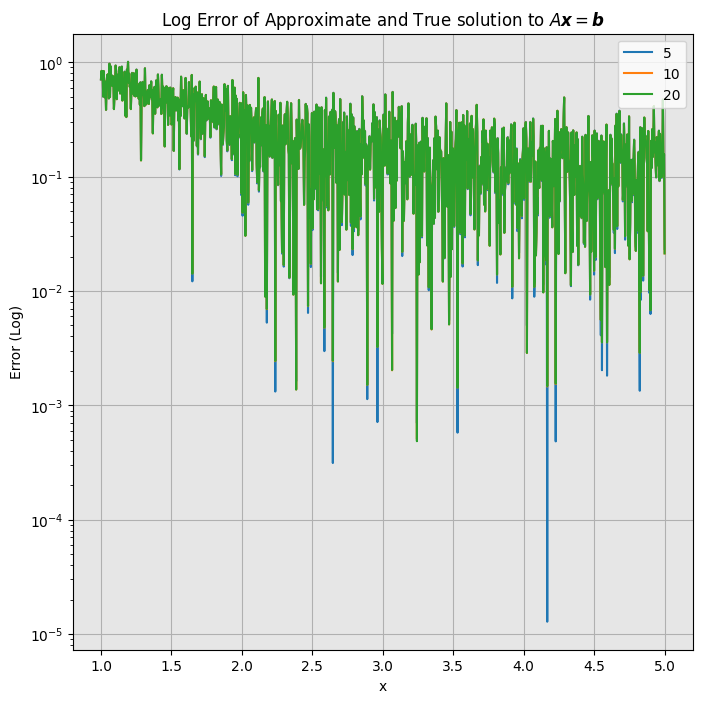

In [54]:
fig, axs = plt.subplots(1, 1, figsize = (8, 8))

f_true = np.linspace(1, 5, size)
lam_true = sm.lambdify(x, f(x), modules=['numpy'])
f_true = f(f_true)
for i, line in enumerate(f_approxs):
    axs.plot(unmapping(xs), np.abs(line - Actual_sol), label=f"{ns[i]}")

axs.set_yscale('log')
axs.legend(loc='upper right')
axs.set_ylabel("Error (Log)")
axs.set_xlabel("x")
axs.grid(True)
fig.gca().set_facecolor((0.9, 0.9, 0.9))
axs.set_title(r"Log Error of Approximate and True solution to $A\boldsymbol{x} = \boldsymbol{b}$")

In [55]:
for i, line in enumerate(f_approxs):
    err = np.linalg.norm(line - Actual_sol, ord = 2) / np.linalg.norm(Actual_sol, ord = 2)
    print(f"Error for n = {ns[i]} : ", err)

Error for n = 5 :  1.2273821990951554
Error for n = 10 :  1.2267317124409314
Error for n = 20 :  1.226730378069317
